## Timeseries practice - Chap 31 from timeseries forcasting with python

This is a walk through of the sample project from Jason Brownlee's Timeseries forecasting with python from his website Mastering Machine Learning. I have walked through the example constructing my own pipeline, adding understandings of the analysis, and learning from his code.

Objectives:
- Understand the basic steps to implementing a ARIMA timeseries forecasting model.

Specifically this notebook contains:
- 

### Import Dataset

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [24]:
#import water useage data from
path = '/Users/ns/projects/study/data/'
file = 'water.csv'
data = pd.read_csv(path+file, header=0, index_col=0, parse_dates=True, squeeze=True)

In [12]:
(data.index.min(), data.index.max())

(Timestamp('1885-01-01 00:00:00'), Timestamp('1963-01-01 00:00:00'))

In [8]:
data.describe()

count     79.000000
mean     512.025316
std       75.685072
min      344.000000
25%      462.000000
50%      503.000000
75%      581.000000
max      662.000000
Name: Water, dtype: float64

### Problem description

Data shows annual water consumption figures for the period 1885 to 1963, 78 years of data. The problem is to predict the annual water consumption. Below is a sample of the data.

In [13]:
data.head()

Year
1885-01-01    356
1886-01-01    386
1887-01-01    397
1888-01-01    397
1889-01-01    413
Name: Water, dtype: int64

#### Construct train and validation datasets

With a small smaple size, will opt for a 85-15 split between the development and validation samples. From there the development set will be split 60/40 as train and test.

In [35]:
split = int(len(data)*0.85)
dev, validate = data[:split], data[split:]

(dev.shape, validate.shape)

((67,), (12,))

In [28]:
train.to_csv(path + 'dev.csv')
validate.to_csv(path + 'validate.csv')

/Users/ns/projects/spanish-elec-demand/es-enrg-dem/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/Users/ns/projects/spanish-elec-demand/es-enrg-dem/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


#### Performance measure

Will use RMSE as the main performance measure. RMSE while less intuituve than MAE will allow us to penelize larger erros more strongly comapred with MSE. This makes sense in this context because predictions will be used for subsequent predictions under a walk forward development model.

In [49]:
from sklearn.metrics import mean_squared_error

#define a function that will be used to evaluate performance
def model_rmse(X_test, yhat):
    
    rmse = np.sqrt(mean_squared_error(X_test, yhat))
    
    return rmse

#### Model evaluation

Evaluate models on a walk-forward validation. This is because the problem is a rolling-forecast type there one step forcast is needed given the data available.


##### Test strategy

Walk forward evaluation is where a prediction is made on the next time slice of the data. After the prediction is made it is stored for evaluation. Then the actual observation for that same data point is added to the model and the process repeats.

Steps:
1. Test data trained on n samples
2. Prediction made for sample n+1 
3. Actual observation for n+1 is added to model
4. Process in steps 1-3 repeated starting from observation n+1



In [37]:
#define a funciton that splits our development dataset

def split(dev, size):
    X = dev.values
    X = X.astype('float32')
    
    train_size = int(len(X) * size)
    
    X_train, X_test = X[:train_size], X[train_size:]
    
    return X_train, X_test

In [244]:
#use a 60/40 train/test split
X_train, X_test = split(dev, 0.6)
(X_train.shape, X_test.shape)

((40,), (27,))

In [295]:
#define a function that carries out the walk-forward validation
#this is our test harness

def walk_forward(X_train, X_test, predcit_func, params, bias):
    history = [x for x in X_train]
    predictions = list()

    for i in range(len(X_test)):
        
        if predcit_func == 'baseline':
            #last day as prediction.
            yhat = baseline(history)
        elif predcit_func == 'arima_model':
            yhat = bias + arima_model(history, params)

        #add prediction to list
        predictions.append(yhat)

        #add observed test value to the history of predictions
        obs = X_test[i]
        history.append(obs)
        print('Predicted = %.3f, Observed = %.3f' % (yhat, obs))
    
    rmse = model_rmse(X_test, predictions)
#    print('RMSE for run: %.3f' %rmse)
        
    return predictions, rmse

In [192]:
def baseline(data):
    return data[-1]

#### Baseline performance (persistence)

Using the year priror as the prediction varaiable we predict the baseline performance of the predictive model.

Any subsequent models wil be evaluated according to this metric.

In [290]:
#run the talk forward test harness and return yhat predictions
Y_hat, rmse = walk_forward(X_train, X_test, 'baseline', None, 0)
rmse

23.836636

### Analysis of data and problem

1. Summary statistics
2. Line plot
3. Density plots
4. Box and wisker plot

In [68]:
dev.describe()

count     67.000000
mean     499.194030
std       74.620908
min      344.000000
25%      458.000000
50%      492.000000
75%      528.000000
max      662.000000
Name: Water, dtype: float64

Mean of series is 499. This is considered the level in the timeseries data. I.e. the baseline if timeseries was a stright line.

Standard deviation is 74 and range is 318. Standard deviation seems small compared with the range of the data. Given this the data does not seem to have a large spread and might be closely packed around the mean. This idea is supported by the 1st and 3rd quantiles.

Data appears to have a slight right skew based on the mean and 2nd quantile.

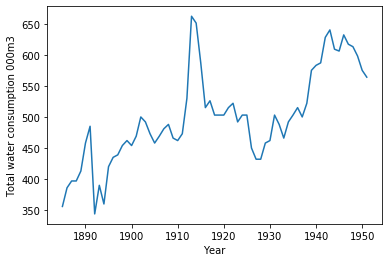

In [81]:
#line plot of data
plt.plot(dev)
plt.xlabel('Year')
plt.ylabel('Total water consumption 000m3')
plt.show()

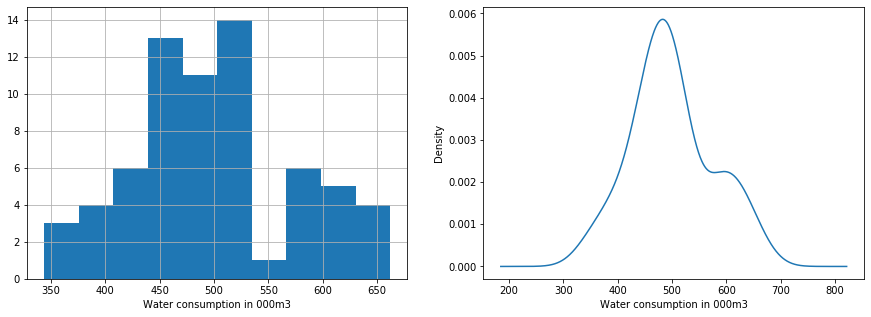

In [90]:
plt.figure(figsize=(15,5))
plt.subplot(121)
dev.hist()
plt.xlabel('Water consumption in 000m3')


plt.subplot(122)
dev.plot(kind='kde')
plt.xlabel('Water consumption in 000m3')
plt.show()

Some observations from the line and histogram charts:

- The data seems to have an increasing trend
- Variability year over year seems to be consistent with the exception of a few large jumps
- distribution is not guassian and has a right skew

Worth consdiering:
- modelling the trend, or multiple trends in order to remove them and make the data set stationary
- applying power transformations in order to account for the non-gaussian shape of the distribution


Confirm there is trend with a Dicky Fuller test.

Null hypothesis is that that data has a trend. For P-val < 0.05 reject the null and assum stationary data set.

In [86]:
from statsmodels.tsa.stattools import adfuller

stationary_test = adfuller(dev)
print('P-val: %.3f' %stationary_test[1])

P-val: 0.228


We fail to reject the null and continue assuming the data has a trend.

#### Box plot per decade

Construct a box plot of the data per 10 years

In [99]:
group_10yr = dev.groupby(pd.Grouper(freq='10YS'))

In [106]:
ten_yr = pd.DataFrame()
for name, group in group_10yr:
    #when number of values in a column is 10 assign the value to the year
    if len(group.values) is 10:
        ten_yr[name.year] = group.values

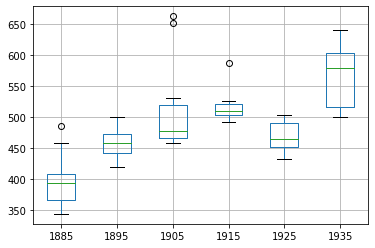

In [108]:
ten_yr.boxplot()
plt.show()

From the box plot:
- Median per decate has quite a lot of variability and is increasing in trend.
- IQRs per 10 year period also shows a lot of variability


In [113]:
means = list()
stds = list()
for yr in ten_yr:
    stats = ten_yr[yr].describe()
    means.append(stats[1])
    stds.append(stats[2])

In [116]:
ten_yr.columns

Int64Index([1885, 1895, 1905, 1915, 1925, 1935], dtype='int64')

Text(0.5, 1.0, 'Standard Deviation per decate')

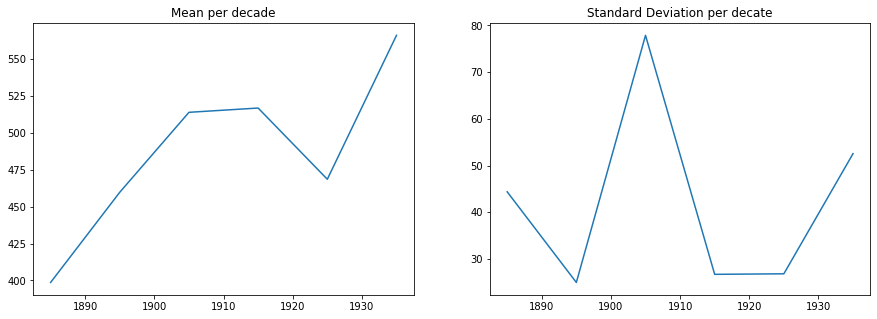

In [119]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ten_yr.columns, means)
plt.title('Mean per decade')
plt.subplot(122)
plt.plot(ten_yr.columns, stds)
plt.title('Standard Deviation per decate')

The last plots here confirm that the mean is rising, and that the decade-to-decade standard deviation is moving between ~30 to ~80. 

### Configure a ARIMA model

ARIMA(p, d, q) where:

- p: is the number of lag observations in he model. Lag order.
- d: the number of times raw observations are differenced. Degree of differencing.
- q: the side of the moving average window. The order of moving average.

ARIMA takes only stationary time series. Therefore will need to difference the dataset before passing it into the model.

##### Configure differncing

Data is nonseasonal. Configure manually and start with differencing of -1 year.

In [153]:
#write function to difference the data
#use the full development set to make stationary

def difference_test(dev, offset):
    diff = list()
    for i in range(1, len(dev)):
        val = dev[i] - dev[i-offset]
        diff.append(val)
        
    #make difference a series and align index lengths    
    stationary = pd.Series(diff)
    stationary.index = dev.index[1:]
    
    p_val = adfuller(stationary)
    
    return stationary, float(p_val[1])
        

In [160]:
stationary, p_val = difference_test(dev, 1)
p_val

1.0491691366720878e-07

In this case we can reject the null and assume the data is stationary with one period offset.

##### Configure lag for p (AutoRegression) and q (MovingAverage)

Make two plots. First for the Autocorrelation function and second for the Partial Autocorrelation Function

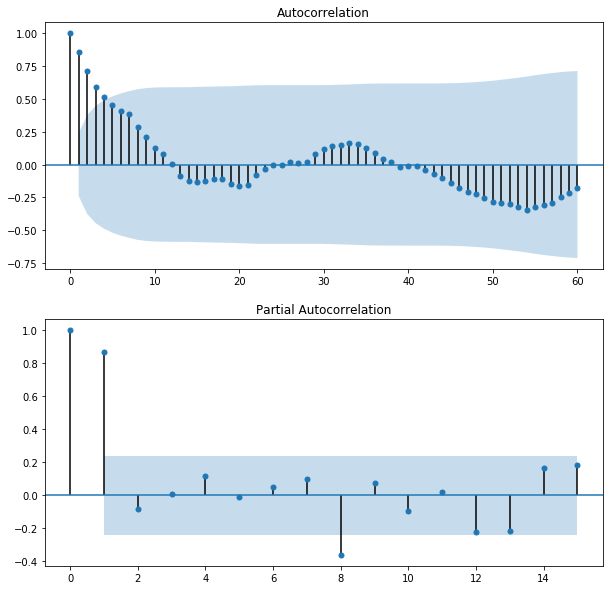

In [170]:
from statsmodels.graphics import tsaplots

plt.figure(figsize=(10,10))
plt.subplot(211)
tsaplots.plot_acf(dev, lags=60, ax=plt.gca())

plt.subplot(212)
tsaplots.plot_pacf(dev, lags=15, ax=plt.gca())
plt.show()

In [201]:
#define a arima model with values of p = 4, d = 1, q = 1

from statsmodels.tsa.arima_model import ARIMA

def arima_model(history, params):
    
    p, q, r = params
    
    model = ARIMA(history, order=(p,q,r))
    
    model_fit = model.fit(trend='nc', disp=0)
    
    prediction = model_fit.forecast()[0]
    
    return prediction

Note that we pass in the original X_train, X_test series objects into the ARIMA function. This is because we used the stationary data set constructed in the difference function to set the parameters of the ARIMA. The parameters of the ARIMA function take care of the modelling of lag, difference, and sliding window.

In [232]:
#test the model with walk_forward test harness
params = (1,0,0)
Y_hat, rmse = walk_forward(X_train, X_test, 'arima_model', params, 0)

In [233]:
rmse

22.395619487858358

ARIMA model performed worse than the persistance model. Appears that our manual tuning of the ARIMA was not sufficient. Use gridsearch to tune the hyperparameters of the ARIMA model

Try grid search over the following ranges:
- p 0 to 4
- d 0 to 2
- q 0 to 4

disable addition of trend constant.


In [242]:
#define function for gridsearch over p,d,q

def grid_search(X_train, X_test, p_vals, d_vals, q_vals):
    best_score, best_cfg = float('inf'), None
    
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                #test the current configuration of p,d,q. if not better, continue to next iteration.
                cfg = (p,d,q)
                try:
                    Y_hat, rmse = walk_forward(X_train, X_test, 'arima_model', params=cfg)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, cfg
                    print('ARIMA%s RMSE %.3f' % (cfg, rmse))    
                except:
                    continue
    print('Best congif %s, Best score %.3f' % (best_cfg, best_score))
    return best_cfg
    

In [243]:
#set ranges for p, d, q
p_val, d_val, q_val = range(0,5), range(0,3), range(0,5)

#run gridsearch
best_cfg = grid_search(X_train, X_test, p_val, d_val, q_val)

ARIMA(0, 0, 1) RMSE 285.831
ARIMA(0, 0, 4) RMSE 78.869
ARIMA(0, 1, 1) RMSE 23.764
ARIMA(0, 1, 2) RMSE 24.098
ARIMA(0, 1, 3) RMSE 26.873
ARIMA(0, 1, 4) RMSE 27.016
ARIMA(0, 2, 1) RMSE 24.077
ARIMA(0, 2, 2) RMSE 23.942
ARIMA(1, 0, 0) RMSE 23.819
ARIMA(1, 1, 0) RMSE 23.781
ARIMA(1, 2, 0) RMSE 29.767
ARIMA(1, 2, 1) RMSE 23.973
ARIMA(1, 2, 2) RMSE 26.238
ARIMA(2, 1, 0) RMSE 23.507
ARIMA(2, 2, 0) RMSE 27.091
ARIMA(3, 1, 0) RMSE 25.971
ARIMA(3, 1, 1) RMSE 26.894
ARIMA(3, 2, 0) RMSE 26.515
ARIMA(3, 2, 1) RMSE 26.123
ARIMA(4, 1, 0) RMSE 26.274
ARIMA(4, 1, 1) RMSE 26.709
ARIMA(4, 2, 0) RMSE 28.049
ARIMA(4, 2, 1) RMSE 26.409
ARIMA(4, 2, 2) RMSE 26.637
Best congif (2, 1, 0), Best score 23.507


Only marginally better than the baseline case. 

### Residual Errors

Check to see if residual errors are guassian with zero mean. Non zero mean would be an indication of bias in our model.  

Run the model with 2,1,0 and investigate errors with a residual function.

In [273]:
#define a resultuals function

def arima_residuals(X_test, Y_hat):

    residuals = [X_test[i] - Y_hat[i] for i in range(len(X_test))]
    
    residuals = pd.DataFrame(residuals)
    
    return residuals

In [248]:
params = (2,1,0)
Y_hat, rmse = walk_forward(X_train, X_test, 'arima_model', params)

In [276]:
residuals = arima_residuals(X_test, Y_hat)
residuals.describe()

,0
count,27.000000
mean,2.403388
std,23.828838
min,-52.103812
25%,-16.202284
50%,-0.459805
75%,18.618704
max,51.284339


##### Plot the residuals

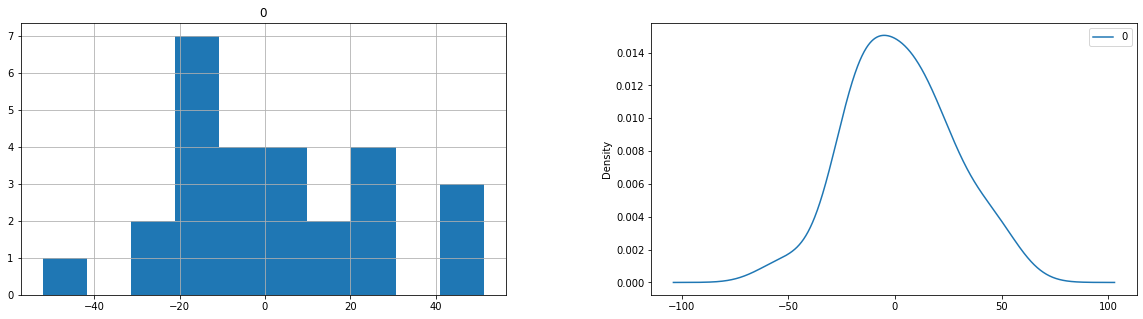

In [287]:
plt.figure(figsize=(20,5))
ax1 = plt.subplot(121)
residuals.hist(ax=ax1)
ax2 = plt.subplot(122)
residuals.plot(kind='kde', ax=ax2)
plt.show()

The non-zero mean indicates a potential bias. One option is to add the bias into the model by adding it to:

y_hat = bias + forecast

Run the model again with the bias term added as the mean of the residual errors.

In [291]:
#
bias = 2.403388
Y_hat, rmse = walk_forward(X_train, X_test, 'arima_model', params, bias)

In [292]:
residuals_biased = arima_residuals(X_test, Y_hat)
residuals_biased.describe()

,0
count,2.700000e+01
mean,-1.186762e-07
std,2.382884e+01
min,-5.450720e+01
25%,-1.860567e+01
50%,-2.863193e+00
75%,1.621532e+01
max,4.888095e+01


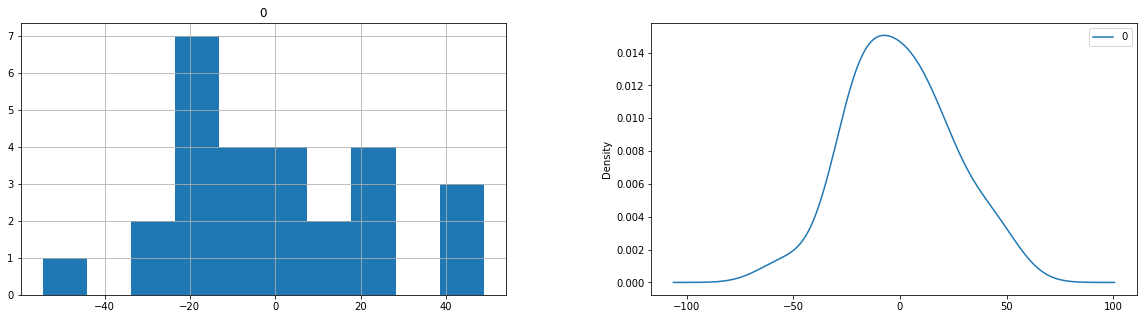

In [293]:
plt.figure(figsize=(20,5))
ax1 = plt.subplot(121)
residuals_biased.hist(ax=ax1)
ax2 = plt.subplot(122)
residuals_biased.plot(kind='kde', ax=ax2)
plt.show()

Seeing the bias in the plots there seems to be little change. Our mean is centred on zero however there still seems to be some amount of right skew.

### Validate Model

Evaluate the parameters and model developed using the test set with the validation set.

Retrain the model and validate using a rolling-forecast model. Use the model test harness with the original dev and validate as X_train and X_test

In [294]:
dev.shape, validate.shape

((67,), (12,))

In [313]:
params = (2,1,0)
bias = 2.403388
Y_hat_val, rmse_val = walk_forward(dev, validate, 'arima_model', params, bias)
rmse_val

Predicted = 568.305, Observed = 549.000
Predicted = 551.791, Observed = 538.000
Predicted = 541.335, Observed = 568.000
Predicted = 572.910, Observed = 575.000
Predicted = 574.611, Observed = 579.000
Predicted = 580.882, Observed = 587.000
Predicted = 589.385, Observed = 602.000
Predicted = 604.344, Observed = 594.000
Predicted = 594.500, Observed = 587.000
Predicted = 589.879, Observed = 587.000
Predicted = 590.119, Observed = 625.000
Predicted = 629.263, Observed = 613.000


16.19372364008069

Plot the predcitions on the validated data vs the actual values.

In [317]:
Y_hat_val = pd.Series(data=Y_hat_val, index=validate.index, dtype='float')

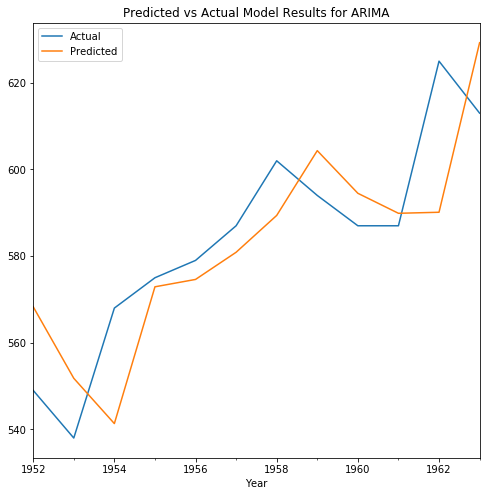

In [324]:
plt.figure(figsize=(8,8))
validate.plot(label='Actual')
Y_hat_val.plot(label='Predicted')
plt.legend(loc='upper left')
plt.title('Predicted vs Actual Model Results for ARIMA')
plt.show()

### Conclusion

The final model looks very similar to the persistance model in the first step. If this is true then:
1. The sample of data is too small to fully exploit any trend or seasonal qualities
2. The data is generated from a stocastic process and therefore can not be modeled i.e. the best model is persistance.

As the data set is limited we will conslude by evaluating the models residuals.

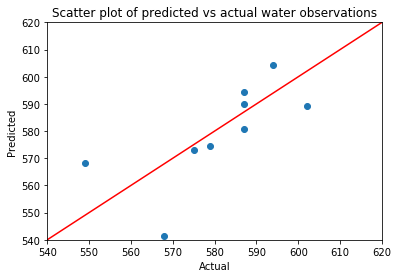

In [333]:
# evaluate and plot residuals
plt.scatter(x=validate, y=Y_hat_val)
plt.title('Scatter plot of predicted vs actual water observations')
plt.xlabel("Actual")
plt.ylabel("Predicted")

linestart = 540
lineend = 620

plt.plot([linestart, lineend], [linestart, lineend], 'k-', color = 'r')
plt.xlim(linestart, lineend)
plt.ylim(linestart, lineend)
plt.show()

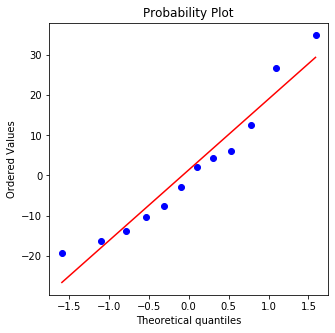

In [329]:
from scipy.stats import probplot

residuals = validate-Y_hat_val

fig, ax = plt.subplots(1,1,figsize=(5,5))

probplot(residuals, plot=ax)
plt.show()